# An end-to-end pipeline for pixel-wise DNN-based TCH regression for Netherlands built around pytorch

This notebook Includes:
1. Data loaders are based on torchgeo.  
    1.1. Allows for on the fly loading of data patches of arbitrary sizes.  Therefore, images do not need to be patchified   beforehand.  
    1.2. Actively maintained
2. Data normalisation based on percentiles derived from GEE for the data in the area of interest.
3. DNN - encoder-decoder network used (MANet) based on segmentation models pytorch.  
    3.1. Easily investigate different architectures and encoders.
4. Inference.    
    4.1. (in memory) chip inference - For the purpose of sanity checks.  
    4.2. (in memory) multiple chip inference - Inference over a small area of interest.  
    4.3. (out-of-memory) large image inference - Inference over large extents of image. Should scale to arbtraily large areas.  
5. Model tracking via weights and biases.  


 #### Details
 This Notebook looks at estimating height (building+tree height) across Netherlands
 based on Sentinel-2 VNIR data. Data has been prepared and exported from GEE.
 Data preparation involved spatio-temporal filtering, radiometric calibration
(coverting from DN to refelectance), computing a height model from Lidar data and downscaling
 to 10m (from 1m). Refer to NS_NB1_DataExtraction_LidarSen2.ipynb for data extraction.

# Import packages

In [41]:
# Load watermark- easily print package versions used and virtual environment details
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [42]:
# System packages
import os
from io import StringIO

# Parallel compute
from tqdm.auto import tqdm
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
import logging
import warnings

# Neural network
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchgeo.samplers import RandomGeoSampler,RandomBatchGeoSampler
from torchgeo.datasets import RasterDataset, stack_samples, BoundingBox
from torchgeo.datasets import BoundingBox

# vis
import matplotlib.pyplot as plt

#Other
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import math

#spatial data
import rasterio
import rasterio as rio
from rasterio.plot import show, show_hist
from rasterio.plot import reshape_as_raster, reshape_as_image

import fiona
import geopandas as gpd
from shapely.geometry import box

import geemap
import ee
# ee.Authenticate()
ee.Initialize()

In [39]:
%watermark -v -m --iversions

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.5.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

logging                    : 0.5.1.2
torch                      : 1.14.0.dev20221018+cu117
segmentation_models_pytorch: 0.3.0
sys                        : 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
geemap                     : 0.17.1
matplotlib                 : 3.6.1
fiona                      : 1.8.21
shapely                    : 1.8.4
geopandas                  : 0.11.1
rasterio                   : 1.2.10
ee                         : 0.1.327
pandas                     : 1.5.0
numpy                      : 1.23.3



## Define parameters

In [7]:
patchSize = 128

## Define Custom Data-loader and Load data

In [8]:
# Create a custom data loader that inherits methods from RasterDataset
# Specify search criteria. Optionally specify input feature band names and rgb bands.
class geemldata(RasterDataset):
    """Initialize a new Dataset instance."""
    seperate_files= False
    filename_glob = "*.tif"
    all_bands = ["B02", "B03", "B04", "B08"]
    rgb_bands = ["B04", "B03", "B02"]

In [9]:
# Load X (VNIR Sentinel-2 image) and Y (HM)
dsx = geemldata(Path(r"C:\Users\coach\myfiles\conservation\Handover\TCH\Data\inputs\DNN\X"))
dsy = geemldata(Path(r"C:\Users\coach\myfiles\conservation\Handover\TCH\Data\inputs\DNN\Y"))
# Create an intersection of the two datasets
ds = dsx & dsy

In [10]:
# Use rasterio to load Y- used to get metadata for parameters needed to create a train-test bounding box
t = rio.open(r"C:\Users\coach\myfiles\conservation\Handover\TCH\Data\inputs\DNN\Y\Y_CHM.tif")

## Create a spatial train-val data split

In [11]:
def spatial_train_test_split(img, dataset, train_portion, output = 'GEE'):
    """
    Splits image area into a train-test bounding box
    
    Args:
        img (raterio image): Image loaded via rasterio
        dataset (torchgeo.Dataset): A torchgeo dataset
        train_portion (float): Proportion of bounding box to use as training area. Between 0 and 1
        output (string): if output is 'GEE', format minx, miny, maxx, maxy (Default). If output is
            'rasterio', format left, right, bottom, top, time_start, time_end
        
    Returns:
        A train and test partition list with information containing bb coordinates of train/test
        image as required for torchgeo data loader.
    """
    train_right = img.bounds.left+train_portion*(img.bounds.right-img.bounds.left)
    train_top = img.bounds.bottom+train_portion*(img.bounds.top-img.bounds.bottom)
    
    if output == 'rasterio':
        train_bb = list([img.bounds.left,train_right, img.bounds.bottom, train_top, *ds.index.bounds[4:6]])
        test_bb = list([train_right,img.bounds.right, train_top, img.bounds.top, *ds.index.bounds[4:6]])
    
    if output == 'GEE':
        train_bb = box(*list([img.bounds.left, img.bounds.bottom,train_right, train_top]))
        test_bb = box(*list([train_right, train_top,img.bounds.right, img.bounds.top]))
    return train_bb, test_bb

In [12]:
train_bb, test_bb = spatial_train_test_split(t, ds, 0.7, output = 'GEE')

## Visualise the train-val area of interest

In [13]:
# Bounding box of AOI
aoi = gpd.GeoDataFrame(gpd.GeoSeries(box(*t.bounds)),  crs='epsg:4326',columns=['geometry'])
# Train bounding box
train = gpd.GeoDataFrame(gpd.GeoSeries(train_bb),  crs='epsg:4326',columns=['geometry'])
# Validation Bounding box
test = gpd.GeoDataFrame(gpd.GeoSeries(test_bb),  crs='epsg:4326',columns=['geometry'])

# Convert to GEE ee.Feature
aoifc = geemap.geopandas_to_ee(aoi)
trainfc = geemap.geopandas_to_ee(train)
testfc = geemap.geopandas_to_ee(test)

# Visualise using geemap
Map = geemap.Map()
Map.centerObject(aoifc, 6)
Map.addLayer(aoifc, name = 'AOI')
Map.addLayer(trainfc, name = 'train area')
Map.addLayer(testfc, name = 'test area')
Map

Map(center=[52.13218936247223, 5.292828738268032], controls=(WidgetControl(options=['position', 'transparent_b…

## Data Normalisation

In [14]:
# Define datsets in GEE (to get summary statistics)

from geeml.utils import getCountry, eeprint

poi = ee.Geometry.Point([5.627073,51.900901]) # Netherlands
aoi = getCountry(poi)

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

covariates = s2.filterBounds(aoi).filterDate('2019-01-01', '2020-01-01')\
.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 25)).select(['B4', 'B3', 'B2', 'B8'])
covs = covariates.median().divide(10000).toFloat().clip(aoi)

dsm = ee.Image('AHN/AHN2_05M_RUW')
dtm = ee.Image('AHN/AHN2_05M_INT')
chm = dsm.unmask(0).subtract(dtm.unmask(0)).rename('chm').unmask(0).clip(aoi)
target = chm

In [15]:
def percentile_norm(input_img, target_img, geometry, scale, min_perc = 1, max_perc = 99):
    """
    Obtains lower and upper percentile for normalising data
    
    Args:
        input_img (ee.Image): Explanatory variables
        target_img (ee.Image): Target/response iage
        geometry (ee.Feature or ee.FeatureCollection): Train BBox
        scale (int): The scale in metres to compute the min and max percentile
        min_perc (int): Default to 1
        max_perc (int): Default to 99
    
    Returns:
        Four lists: 
            minimum percentile value per input band
            maximum percentile value for the target band
            minimum percentile value per input band
            maximum percentile value for the target band
    
    """
    iminp = input_img.reduceRegion(ee.Reducer.percentile([min_perc]),\
                                   geometry = geometry.geometry(), scale = scale, maxPixels = 1e13).values().getInfo()
    imaxp = input_img.reduceRegion(ee.Reducer.percentile([max_perc]),\
                                   geometry = geometry.geometry(), scale = scale, maxPixels = 1e13).values().getInfo()
    
    tminp, tmaxp = target_img.reduceRegion(ee.Reducer.percentile([min_perc, max_perc]),\
                    geometry = geometry.geometry(), scale = scale, maxPixels = 1e13).values().getInfo()
    
    return iminp, imaxp, [tminp], [tmaxp]   

In [17]:
# Utility function to convert min max lists to tensors
def listTondTensor(output_dims, statlist):
    """
    Convert min max values to specified tensor dims (1, output dims)
    
    Args:
        output dims (tuple): dimensions of output (nbands, height, width)
        statlist (List): list to convert to multi demension tensor. 1 value per band
    
    Returns:
        Tensor of dimensions (1, nbands, h, w) 
        
    """
    out = torch.full(output_dims, statlist[0])
    for band in range(1, output_dims[0]):
        out[band,:,:] = torch.full((1, output_dims[1], output_dims[2]), statlist[band])
    return out

In [18]:
# Functions that are passed to the data loader to normalise input and target images
def normalise_input(image):
    image = torch.nan_to_num(image['image'], nan=0.0, posinf= 0.0, neginf= 0.0)
    image = (image-listTondTensor((4,image.shape[1], image.shape[2]), imin))/\
    ((listTondTensor((4,image.shape[1], image.shape[2]), imax)-listTondTensor((4,image.shape[1], image.shape[2]), imin)))
    return {"image": image}

def normalise_target(target):
    target = target['image']
    target = torch.nan_to_num(target, nan=0.0, posinf= 0.0, neginf= 0.0)
    minI = torch.full((target.shape[1], target.shape[2]), target_min[0])
    maxI = torch.full((target.shape[1], target.shape[2]), target_max[0])
    target = (target-minI)/(maxI-minI)
    return {"target": target}

In [19]:
#  Get stats for normalisation
imin, imax, target_min, target_max  = percentile_norm(covs, target, trainfc, 1000)

print(imin, imax)
print(target_min, target_max)

[0.030743865519661805, 0.04055830163786685, 0.030674200236855312, 0.057728721769827435] [0.11168083065588559, 0.12934088659551524, 0.13239098955121395, 0.4110359189839199]
[0.11603797784472372] [6.602900946759721]


## Setup Data Loader

In [20]:
# Get train and test BBox in rasterio format that are passed to data loaders.
# Therefore, only loads data within region
train_bb, test_bb = spatial_train_test_split(t, ds, 0.7, output = 'rasterio')

In [21]:
#  Load data with normalisation
dsx = geemldata(Path(r"C:\Users\coach\myfiles\conservation\Handover\TCH\Data\inputs\DNN\X"), transforms = normalise_input)
dsy = geemldata(Path(r"C:\Users\coach\myfiles\conservation\Handover\TCH\Data\inputs\DNN\Y"), transforms = normalise_target)
ds = dsx & dsy

#Get max no. of samples (length of epoch)
sampler_size = patchSize*ds.res
def get_bbox_area(box):
    return (box.maxx - box.minx) * (box.maxy - box.miny)
sampler_len = int(get_bbox_area(ds.bounds)/(sampler_size*sampler_size))

# Create Batch data loaders
train_sampler = RandomBatchGeoSampler(ds, size = patchSize, batch_size = 16, length = 10000, roi = BoundingBox(*train_bb))
val_sampler = RandomBatchGeoSampler(ds, size = patchSize, batch_size = 16, length = 1000, roi = BoundingBox(*test_bb))
traindl = DataLoader(ds, batch_sampler = train_sampler, num_workers= 5, pin_memory= True)
valdl = DataLoader(ds, batch_sampler = val_sampler, num_workers= 5, pin_memory= True)

<AxesSubplot: >

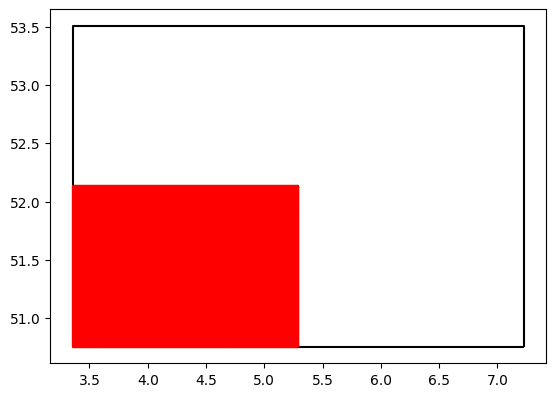

In [190]:
# Plot the location of samples
dataset = ds
minx, maxx, miny, maxy, mint, maxt = dataset.bounds
roi = BoundingBox(minx, (minx + maxx) / 2, miny, (miny + maxy) / 2, mint, maxt)
sampler = GridGeoSampler(dataset, size= 128, stride=64, roi=roi)

dataset_bounds = gpd.GeoSeries(box(minx, miny, maxx, maxy))
roi_bounds = gpd.GeoSeries(box(minx, miny, (minx + maxx) / 2, (miny + maxy) / 2))
# Sample some bounding boxes
samples = gpd.GeoSeries([box(b[0], b[2], b[1], b[3]) for b in sampler])

ax = dataset_bounds.boundary.plot(color="black")
roi_bounds.boundary.plot(ax=ax, color="green")
samples.boundary.plot(ax=ax, color="red")

## Define Model architecture

In [22]:
# model.py
import torch.nn as nn
import segmentation_models_pytorch as smp
model = smp.MAnet(
    encoder_name="timm-resnest50d",   # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels= 4,           # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes = 1,              # model output channels (number of classes in your dataset)
    activation = 'identity')


In [23]:
# print(model)

## Initialise Weights and Biases for tracking

In [33]:
import wandb

# Add config details
config = dict(learning_rate = 1e3,
              epochs = 5,
              batch_size = 16,
              epoch_length = 10000,
              patchSize = 128,
              architecture = 'MAnet with timm-resnest50d encoder')

wandb.init(config = config, project="CNN-biomass")

Learning Rate,▁▁▂▂▃▄▅▆▆▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
Train loss,█▆▄▃▃▃▃▃▁▂▃▂▂▃▃▃▁▂▂▂▂▂▂▂▂▃▃▂▃▂▃▂▂▂▁▁▂▂▂▂
validation loss,▄▂▃▃▃▃▃▃▇▇██████▃▅▄▄▄▄▄▃▁▁▂▂▂▂▂▂▂▂▂▂▂▁▁▁
Learning Rate,0.0
Train loss,0.16855
validation loss,0.06221


## Define training loop

In [34]:
def train (data_loader, model, optimiser, device):
    """
    Does training for a single epoch
    
    Args:
        data_loader: pytorch data loader
        model: pytorch model
        optimizer: optimizer
        device: cuda/cpu
    
    Returns:
        metrics
    """
    # calculate number of batches
    num_batches = len(data_loader)
    # init tqdm to track progress
    tk0 = tqdm(data_loader, total = num_batches)
    
    
    trainLoss = 0
    samples = 0
    # put the model in train mode
    model.train()
    # Iterate through each batch of data in the data loader
    for data in tk0:
        # in our dataset class
        inputs = data['image']
        targets = data['target']
        
        # move inputs/targets to cuda/cpu device
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        # Forward step
        outputs = model(inputs)
        # calculate loss
        loss = nn.MSELoss()
        loss = loss(outputs, targets.view(-1, 1, patchSize, patchSize).type(torch.cuda.FloatTensor))
        
        #Backward
        # zero grad the optimizer
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        
        trainLoss += loss.item()*targets.shape[0]
        samples += targets.shape[0]
        tk0.set_description(f'loss (mse): {(trainLoss/samples):.3f}')
        wandb.log({"Train loss": (trainLoss/samples), "Learning Rate":optimizer.param_groups[0]["lr"]})
        
    tk0.close()

## Define evaluation loop

In [35]:
def evaluate(data_loader, model):
    """
     evaluation function to calculate loss on validation set for one epoch
 
     Args:
        dataset: dataset class 
        data_loader: torch dataset loader
        model: model

     Returns: Average loss over batches
    """
   
    # init val_loss to 0
    valLoss = 0
    samples = 0 
    # put model in eval mode
    model.eval()
    
    # calculate number of batches and init tqdm
    num_batches = len(data_loader)
    tk0 = tqdm(data_loader, total=num_batches)
    #no grad, saves memory
    with torch.no_grad():
        for d in tk0:
            inputs = d["image"]
            targets = d["target"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            output = model(inputs)
            loss = nn.MSELoss()
            loss = loss(output, targets.view(-1, 1, patchSize, patchSize).type(torch.cuda.FloatTensor))
            # add loss to final loss
            valLoss += loss.item()*targets.shape[0]
            samples += targets.shape[0]
            tk0.set_description(f'loss (mse): {(valLoss/samples):.3f}')
            wandb.log({"validation loss": (valLoss/samples)})
    # close tqdm
    tk0.close()
    # return average loss over all batches
    return valLoss / samples

## Start training

In [37]:
# train.py

if __name__ == "__main__":
    # cuda/cpu device
    device = "cuda"
    # let's train for 10 epochs
    epochs = 10
    
    # simple Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch= int(10000/16), epochs= epochs)

    # move model to device
    model.to(device)
    
    for epoch in range(1, epochs+1):
        print(f"Training Epoch: {epoch}")
        train(traindl, model, optimizer, device=device)
        
        print(f"Validation Epoch: {epoch}")
        # calculate validation loss
        val_log = evaluate(valdl,model)
        
        # Optional
        wandb.watch(model)
        
        if epoch == 1:
            val_loss = val_log
            print(f'Saving model with loss: {val_loss}')
            
            #savemodel
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, r"C:\Users\coach\myfiles\conservation\Handover\TCH\Models\chkpt.pt")
            
        if (epoch>1 and val_log<val_loss):
            val_loss = val_log
            print(f'Saving model with loss: {val_loss}')
            
            #savemodel
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, r"C:\Users\coach\myfiles\conservation\Handover\TCH\Models\chkpt.pt")
            

Training Epoch: 1


loss (mse): 0.180: 100%|█████████████████████████████████████████████████████████████| 625/625 [06:08<00:00,  1.70it/s]


Validation Epoch: 1


loss (mse): 0.081: 100%|███████████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  4.12it/s]


Saving model with loss: 0.08125317427179506
Training Epoch: 2


loss (mse): 0.168: 100%|█████████████████████████████████████████████████████████████| 625/625 [06:15<00:00,  1.66it/s]


Validation Epoch: 2


loss (mse): 0.079: 100%|███████████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  3.98it/s]


Saving model with loss: 0.0790827380072686
Training Epoch: 3


loss (mse): 0.195: 100%|█████████████████████████████████████████████████████████████| 625/625 [06:22<00:00,  1.63it/s]


Validation Epoch: 3


loss (mse): 0.081: 100%|███████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.85it/s]


Training Epoch: 4


loss (mse): 0.201: 100%|█████████████████████████████████████████████████████████████| 625/625 [06:20<00:00,  1.64it/s]


Validation Epoch: 4


loss (mse): 0.077: 100%|███████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.23it/s]


Saving model with loss: 0.07669839296009272
Training Epoch: 5


loss (mse): 0.166: 100%|█████████████████████████████████████████████████████████████| 625/625 [06:20<00:00,  1.64it/s]


Validation Epoch: 5


loss (mse): 0.072: 100%|███████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.16it/s]


Saving model with loss: 0.07189713733931703
Training Epoch: 6


loss (mse): 0.157: 100%|█████████████████████████████████████████████████████████████| 625/625 [06:57<00:00,  1.50it/s]


Validation Epoch: 6


loss (mse): 0.080: 100%|███████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.84it/s]


Training Epoch: 7


loss (mse): 0.189:  23%|██████████████▏                                              | 145/625 [01:49<06:02,  1.33it/s]


KeyboardInterrupt: 

## Plot examples

In [156]:
sampler2 = RandomGeoSampler(ds, size = patchSize, length = 1)
dl2 = DataLoader(ds, batch_size = 1, sampler = sampler2, collate_fn = stack_samples)

for sample in dl2:
    model.eval()
    image = sample['image']
    target = sample['target']
    print(image.shape)
    image = image.to(device, dtype=torch.float)
    output = model(image)
    loss = nn.MSELoss()
    loss = loss(output, target.view(-1, 1, patchSize, patchSize).type(torch.cuda.FloatTensor))
    print('MSE:',loss.item())
    show(target.detach().cpu()-output.detach().cpu(), title='difference')
    show(target.detach().cpu(), title='Target')
    print('target minmax',target.min(), target.max())
    show(output.detach().cpu(), title='Prediction')
    print('output minmax',output.detach().cpu().min(), output.detach().cpu().max())

torch.Size([1, 4, 128, 128])
MSE: 9.424349991604686e-05


TypeError: view() received an invalid combination of arguments - got (type), but expected one of:
 * (torch.dtype dtype)
      didn't match because some of the arguments have invalid types: ([31;1mtype[0m)
 * (tuple of SymInts size)
      didn't match because some of the arguments have invalid types: ([31;1mtype[0m)


## Inference

#### In memory image chips

In [24]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from torchgeo.samplers import RandomGeoSampler,RandomBatchGeoSampler, GridGeoSampler
from torchgeo.datasets import RasterDataset, stack_samples, BoundingBox

model = smp.MAnet(
    encoder_name="timm-resnest50d",   # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels= 4,           # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes = 1,              # model output channels (number of classes in your dataset)
    activation = 'identity')

In [25]:
class geemldata(RasterDataset):
    """Initialize a new Dataset instance."""
    seperate_files= False
    filename_glob = "*.tif"
    all_bands = ["B02", "B03", "B04", "B08"]
    rgb_bands = ["B04", "B03", "B02"]

# load image
dsx = geemldata(Path(r"C:\Users\coach\myfiles\conservation\data\DNN\X"), transforms = normalise_input)
dsy = geemldata(Path(r"C:\Users\coach\myfiles\conservation\data\DNN\Y"), transforms = normalise_target)
ds = dsx & dsy

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = "cuda"
device = torch.device(device)
#load model
checkpoint = torch.load(r"C:\Users\coach\myfiles\conservation\models\chkpt.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE: 0.08850722014904022


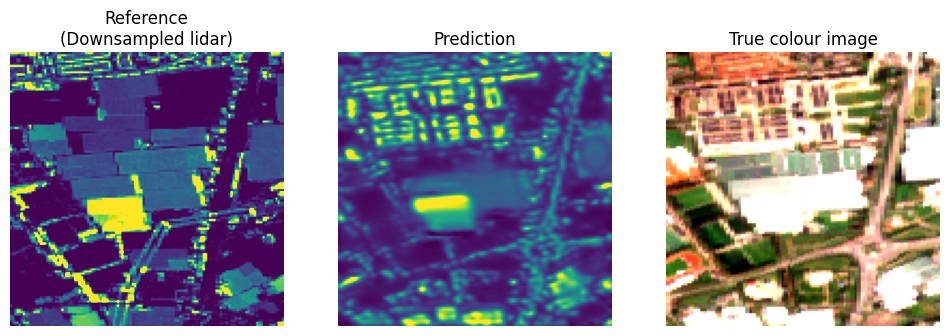

In [35]:
import numpy as np
sampler2 = RandomGeoSampler(ds, size = patchSize, length = 1)
dl2 = DataLoader(ds, batch_size = 1, sampler = sampler2, collate_fn = stack_samples)

for sample in dl2:
    model.eval()
    image = sample['image']
    target = sample['target']
    image = image.to(device, dtype=torch.float)
    output = model(image)
    loss = nn.MSELoss()
    loss = loss(output, target.view(-1, 1, patchSize, patchSize).type(torch.cuda.FloatTensor))
    print('MSE:',loss.item())
    
    fig, ax1 = plt.subplots(1, 3, figsize=(12, 6))
    target = target.reshape(patchSize,patchSize,1)
    vmin, vmax = np.nanpercentile(target, (5,95))
    ax1[0].imshow(target, vmin=vmin, vmax=vmax, cmap = 'viridis')
    ax1[0].set_title("Reference\n(Downsampled lidar)")
    ax1[0].axis('off')
    oput = output.detach().cpu().reshape(patchSize,patchSize,1)
    ax1[1].imshow(oput.numpy(), vmin=vmin, vmax=vmax, cmap = 'viridis')
    ax1[1].set_title("Prediction")
    ax1[1].axis('off')
    iput = torch.squeeze(image)[:3].permute(1, 2, 0).detach().cpu()
    vmin, vmax = np.nanpercentile(iput, (5,95))
    ax1[2].imshow(iput)
    ax1[2].set_title("True colour image")
    ax1[2].axis('off')
    fig.savefig(r"C:\Users\coach\myfiles\conservation\admin\reports\biomass\pred.png", bbox_inches='tight')
    plt.show()

## Inference for a region

In [27]:
def normalise_input(image):
    image = torch.nan_to_num(image, nan=0.0, posinf= 0.0, neginf= 0.0)
    image = (image-listTondTensor((4, image.shape[1], image.shape[2]), imin))/\
    ((listTondTensor((4,image.shape[1], image.shape[2]), imax)-listTondTensor((4,image.shape[1], image.shape[2]), imin)))
    return image

def denormalise_output(image):
    image = torch.nan_to_num(image, nan=0.0, posinf= 0.0, neginf= 0.0)
    min_i = torch.full((image.shape[0], image.shape[1]), target_min[0], device= device)
    max_i = torch.full((image.shape[0], image.shape[1]), target_max[0], device= device)
    denorm_img = (image * (max_i - min_i)) + min_i
    return denorm_img

## If data fits in memory.

(data not made available) Can be obtained by clipping input features. Must fit in memory

In [73]:
def roi_inference(infile, model, outfile):
    """
    Run inference for a image over a region of interest (roi).
    Image must fit into memory
    
    Args:
        infile (string): Path to the image
        model: A trained pytorch model
        outfile: The save destination and filename
    
    Returns:
        classified/regressed image
        
    """
    # Read patch
    with rio.open(input_image) as src:
        i_arr = src.read()#nbands, nrows, ncols(4, 128, 128)
        i_meta = src.profile
        i_meta.update(count=1)

    w, h = i_arr.shape[1], i_arr.shape[2]
    image = normalise_input(torch.from_numpy(i_arr))
    image = torch.from_numpy(np.expand_dims(image, axis=0)).to(device, dtype=torch.float)#(1, 128, 128, 4)
    hpad = math.ceil(h/32)*32-h
    wpad = math.ceil(w/32)*32-w
    transform = transforms.Pad((0, 0, hpad, wpad))
    # add padding to image
    image = transform(image)
    model.eval()
    output = model(image)#(1,1,)
    #denormalize output
    output = denormalise_output(output.squeeze())
    # remove padding
    output = output[0:w, 0:h].detach().cpu()
    plt.imshow(output.numpy())
    # save output
    with rio.open(Path(outfile), 'w', **i_meta) as dst:
        dst.write(output, 1)

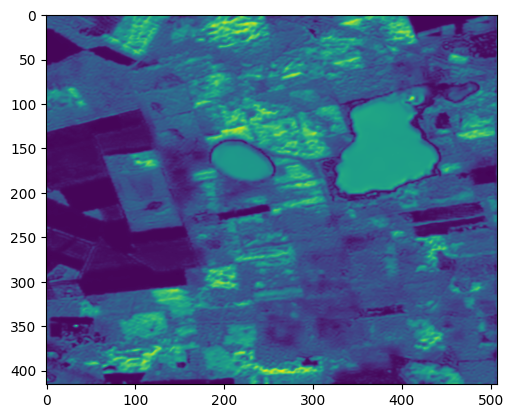

In [74]:
input_image = r"C:\Users\coach\myfiles\conservation\data\tch_results\s2clip.tif"
dd = r"C:/Users/coach/myfiles/conservation/data/tch_results/pred_MANet_TCH_Netherlands.tif"

roi_inference(input_image, model = model, outfile = dd)

## If data does not fit in memory

In [35]:
def inference(infile, model, outfile, patchSize, num_workers=4):
    """
    Run inference using model on infile block-by-block and write to a new file (outfile). 
    In the case, that the infile image width/height is not exactly divisible by 32, padding
    is added for inference and removed prior to the outfile being saved.
    
    Args:
        infile (string): Path to input image/covariates
        model (pth file): Loaded trained model/checkpoint
        outfile (string): Path to save predicted image
        patchSize (int): Must be a multiple of 32. Size independent of model input size.
        num_workers (int): Num of workers to parralelise across
        
    Returns:
        A tif saved to the outfile destination
        
    """

    with rio.open(infile) as src:
        
        logger = logging.getLogger(__name__)

        # Create a destination dataset based on source params. The
        # destination will be tiled, and we'll process the tiles
        # concurrently.
        profile = src.profile
        profile.update(blockxsize= patchSize, blockysize= patchSize, tiled=True, count=1)

        with rio.open(Path(outfile), "w", **profile) as dst:
            windows = [window for ij, window in dst.block_windows()]

            # use a lock to protect the DatasetReader/Writer
            read_lock = threading.Lock()
            write_lock = threading.Lock()

            def process(window):
                with read_lock:
                    src_array = src.read(window=window)#nbands, nrows, ncols(4, h, w)
                    w, h = src_array.shape[1], src_array.shape[2]
                    image = normalise_input(torch.from_numpy(src_array))
                    image = torch.from_numpy(np.expand_dims(image, axis=0)).to(device, dtype=torch.float)#(1, h, w, 4)
                    hpad = math.ceil(h/32)*32-h
                    wpad = math.ceil(w/32)*32-w
                    transform = transforms.Pad((0, 0, hpad, wpad))
                    # add padding to image
                    image = transform(image)
                    model.eval()
                    output = model(image)#(1,1,h,w)
                    #denormalize output
                    output = denormalise_output(output.squeeze())
                    # remove padding
                    result = output[0:w, 0:h].detach().cpu()
                    # plt.imshow(result.numpy())

                with write_lock:
                    dst.write(result, 1, window=window)

            # We map the process() function over the list of
            # windows.
            with tqdm(total=len(windows), desc = os.path.basename(outfile)) as pbar:
                with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
                    futures = {executor.submit(process, window): window for window in windows}
                    
                    try:
                        for future in concurrent.futures.as_completed(futures):
                            future.result()
                            pbar.update(1)
                                    
                    except Exception as ex:
                        logger.info('Cancelling...')
                        executor.shutdown(wait=False, cancel_futures=True)
                        raise ex        

In [43]:
input_image = r"C:\Users\coach\myfiles\conservation\Handover\TCH\Data\inputs\DNN\X\X_S2VNIR.tif"
dd = r"C:\Users\coach\myfiles\conservation\Handover\TCH\Data\outputs\DNN/pred_MANet_TCH_Netherlands_windows.tif"

inference(infile = input_image, model = model, outfile = dd, patchSize = 512, num_workers=10)

pred_MANet_TCH_Netherlands_windows.tif:   0%|          | 0/5185 [00:00<?, ?it/s]

## Wishlist
- Investigate sparse target (GEDI)
- Test different architectures, loss functions
- Inference pipeline- add rotation inference to overcome artefacts